In [12]:
# Imports
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import pandas as pd
from scipy.ndimage.measurements import center_of_mass as CoM # Scipy center of mass function

In [13]:
# MNIST specific import
import torch
import torch
import torchvision
from torchvision      import datasets
from torchvision      import transforms
from torch.utils.data import DataLoader
    
loader_kwargs = {'num_workers':8, 'batch_size':1, 'shuffle':False, 'drop_last':False}

data_root = "/media/hdd1/kai/datasets/mnist/"
transform = transforms.Compose( [transforms.ToTensor()] )
data      = datasets.MNIST(root=data_root, train=True, download=False, transform=transform)
dataloader = DataLoader(data, **loader_kwargs)

In [14]:
# Set up variables for logging results
# Centroid calcuations
centroids_x = []; centroids_y = []

In [15]:
# Percentage calculations
pix_totals = []; p_fill = []; imsize = 28

In [16]:
# List of sample images
digits = []

In [17]:
# Perform analysis of the image data
for idx, (image, _) in enumerate(dataloader):
    # Convert Torch tensor to numpy array
    image = image.view(imsize, imsize).numpy()
    
    # Get the weighted centroid position
    com = CoM(image)
    
    # check if computation returned NaN -- happens when centroid location is non-sensical
    if com[0] != com[0]:
        del image
        continue
    else:
        centroids_x.append(int(com[0]))
        centroids_y.append(int(com[1]))
    
    # Binarize the image in order to compute the percentage filled
    image = np.where(image > 0.0, 1.0, 0.0)
    pix_totals.append( np.sum(image) )
    p_fill.append( round(pix_totals[-1] / (imsize**2), 2) )
    
    if idx < 16:
        digits.append(image)

In [38]:
# Centroid denisty data
# The MNIST centroids are so close together, that the Wald test inside the
# denisty plot function crashes. This test computes a covariance and inverse
# covariance matrix between the two series centroids_x and centroids_y. But,
# because of the perfect correlation between the two series, the test returns
# a singluar covariance matrix, which cannot be inverted, and the test crashes.
# Therefore, it is necessary to add a small amount of noise to each data series
# in order to avoid this problem.
# https://stackoverflow.com/questions/44305456/why-am-i-getting-linalgerror-singular-matrix-from-grangercausalitytests
noise = np.random.rand(len(centroids_x), ) * 0.00001
x = np.asarray(centroids_x) + noise
y = np.asarray(centroids_y)
df = pd.DataFrame( {'x': x, 'y' : y} )

In [39]:
df.corr()

,x,y
x,1.00000,0.00542
y,0.00542,1.00000


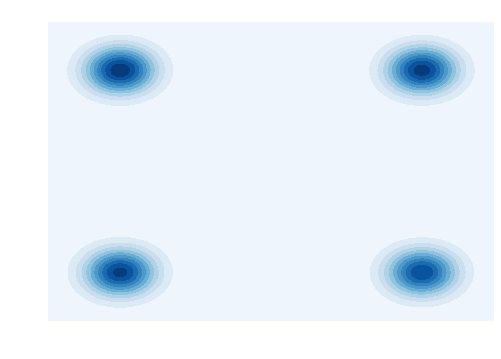

In [20]:
# Plot
plt.style.use('seaborn')
plt.title('Density of MNIST Digit Centroids', fontsize = "large", color="white")

# Density plot
sns.kdeplot(df.x, df.y, cmap="Blues", shade=True, gridsize=250)

# Set axes limits
# plt.xlim(x1, x2); plt.ylim(y1, y2)

# Set labels and tick colors
plt.ylabel("Average Weighted Y-Coordinate", color = "white")
plt.xlabel("Average Weighted X-Coordinate", color = "white")
plt.xticks(color="white")
plt.yticks(color="white")

plt.savefig("centroid_density_MNIST_digits.png".format(imsize), dpi=300, facecolor='#443941')

In [21]:
# Data for fill percentage calculation
pdf = pd.DataFrame( {'x' : pix_totals, 'y' : p_fill} )

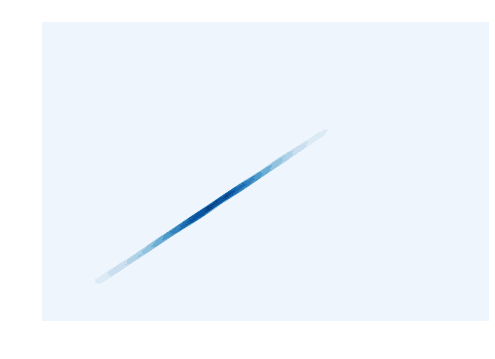

In [27]:
# Plot
sns.kdeplot(pdf.x, pdf.y, cmap="Blues", shade=True, gridsize=250)
# Set axes limits
# plt.xlim(0, 300)
# plt.ylim(y_min, 0.5)

plt.title('Density of MNIST Image Fill Percentages', fontsize = "large", color="white")
plt.xlabel("Binarized Pixel Total", color = "white")
plt.ylabel("Image Fill Percentage", color = "white")
plt.xticks(color="white")
plt.yticks(color="white")

plt.savefig("p-fill_density_plot_mnist_digits.png".format(imsize), dpi=300, facecolor='#443941')

In [23]:
print(digits[0].shape)

(28, 28)


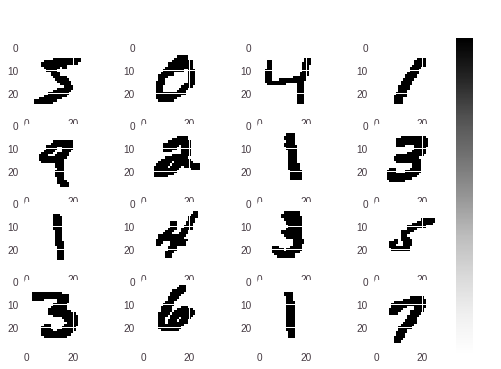

In [24]:
n_row = 4; n_col = 4
fig, axes = plt.subplots(n_row, n_col)
fig.suptitle("Selection of MNIST Digits", color="white")

img = None; im_num = 0
for i in range(0, n_row):
    for j in range(0, n_col):
        img = axes[i,j].imshow(digits[im_num])
        axes[i,j].spines['bottom'].set_color('white')
        axes[i,j].spines['top'].set_color('white')
        axes[i,j].spines['left'].set_color('white')
        axes[i,j].spines['right'].set_color('white')
        axes[i,j].xaxis.label.set_color('white')
        axes[i,j].yaxis.label.set_color('white')
        axes[i,j].tick_params(axis='x', colors='#443941')
        axes[i,j].tick_params(axis='y', colors='#443941')
        im_num += 1

# Colorbar
cbar_axes = fig.add_axes([0.9, 0.1, 0.03, 0.8])
cbar = plt.colorbar(img, cax=cbar_axes)
cbar.ax.yaxis.set_tick_params(color="white")
cbar.outline.set_edgecolor(color="white")
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color="white")

plt.savefig("selection_of_MNIST_digits.png", dpi=300, facecolor='#443941')